In [1]:
!pwd

/global/cfs/cdirs/m4334/jerry/climsim3_dev/online_testing/baseline_models/resLSTM/training


In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime

/Users/katiefrields/Documents/GitHub/climsim3/.conda/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [3]:
# def add_time_dim(xda):
#     xda = xda.expand_dims(time = [datetime.now()])
#     return xda
# # /pscratch/sd/j/jerrylin/coupled_output/debug/debug_run/run
# ds_mli = xr.open_mfdataset('/pscratch/sd/j/jerrylin/coupled_output/debug/debug_run/run/remap_run.eam.mli.*.nc', preprocess = add_time_dim)
# ds_mlis = xr.open_mfdataset('/pscratch/sd/j/jerrylin/coupled_output/debug/debug_run/run/remap_run.eam.mlis.*.nc', preprocess = add_time_dim)
# ds_mlo = xr.open_mfdataset('/pscratch/sd/j/jerrylin/coupled_output/debug/debug_run/run/remap_run.eam.mlo.*.nc', preprocess = add_time_dim)
# ds_mlos = xr.open_mfdataset('/pscratch/sd/j/jerrylin/coupled_output/debug/debug_run/run/remap_run.eam.mlos.*.nc', preprocess = add_time_dim)

# ds_mli['time'] = ds_mlos['time']
# ds_mlis['time'] = ds_mlos['time']
# ds_mlo['time'] = ds_mlos['time']

# ds_mli_before = ds_mli.isel(time = slice(0,5))
# ds_mlis_before = ds_mlis.isel(time = slice(0,5))
# ds_mlo_before = ds_mlo.isel(time = slice(0,5))
# ds_mlos_before = ds_mlos.isel(time = slice(0,5))

# ds_mli_after = ds_mli.isel(time = slice(5,10))
# ds_mlis_after = ds_mlis.isel(time = slice(5,10))
# ds_mlo_after = ds_mlo.isel(time = slice(5,10))
# ds_mlos_after = ds_mlos.isel(time = slice(5,10))


In [29]:
grid_info = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/grid_info/ClimSim_low-res_grid-info.nc')
lon = grid_info['lon'].values
lat = grid_info['lat'].values
lon = ((lon + 180) % 360) - 180

In [5]:
ds_grid = xr.open_dataset('/global/cfs/cdirs/m4334/jerry/climsim3_dev/grid_info/ClimSim_low-res_grid-info.nc')
grid_area = ds_grid['area']

ds_nn = xr.open_mfdataset('/pscratch/sd/j/jerrylin/coupled_output/finetune_long/finetune_long_run/run/finetune_long_run.eam.h2.*.nc')
ds_sp = xr.open_mfdataset('/pscratch/sd/j/jerrylin/coupled_output/mmf_ref/mmf_ref_run/mmf_ref_1230_quick.eam.h2.*.nc')

def zonal_mean_area_weighted(data, grid_area, lat):
    # Define latitude bins ranging from -90 to 90, each bin spans 10 degrees
    bins = np.arange(-90, 91, 10)  # Create edges for 10 degree bins

    # Get indices for each lat value indicating which bin it belongs to
    bin_indices = np.digitize(lat.values, bins) - 1

    # Initialize a list to store the zonal mean for each latitude bin
    data_zonal_mean = []

    # Iterate through each bin to calculate the weighted average
    for i in range(len(bins)-1):
        # Filter data and grid_area for current bin
        mask = (bin_indices == i)
        data_filtered = data[mask]
        grid_area_filtered = grid_area[mask]

        # Check if there's any data in this bin
        if data_filtered.size > 0:
            # Compute area-weighted average for the current bin
            weighted_mean = np.average(data_filtered, axis=0, weights=grid_area_filtered)
        else:
            # If no data in bin, append NaN or suitable value
            weighted_mean = np.nan

        # Append the result to the list
        data_zonal_mean.append(weighted_mean)

    # Convert list to numpy array
    data_zonal_mean = np.array(data_zonal_mean)

    # The mid points of the bins are used as the representative latitudes
    lats_mid = bins[:-1] + 5

    return data_zonal_mean, lats_mid

# ds2 = xr.open_dataset(data_path + 'data_grid/E3SM_ML.GNUGPU.F2010-MMF1.ne4pg2_ne4pg2.eam.h0.0001-01.nc')
lat = ds_grid.lat
lon = ds_grid.lon
level = ds_grid.lev.values

def zonal_mean(var):
    var_re = var.reshape(-1,384,var.shape[-1])
    var_re = np.transpose(var_re, (1,0,2))
    var_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_re, grid_area, lat)
    return var_zonal_mean, lats_sorted

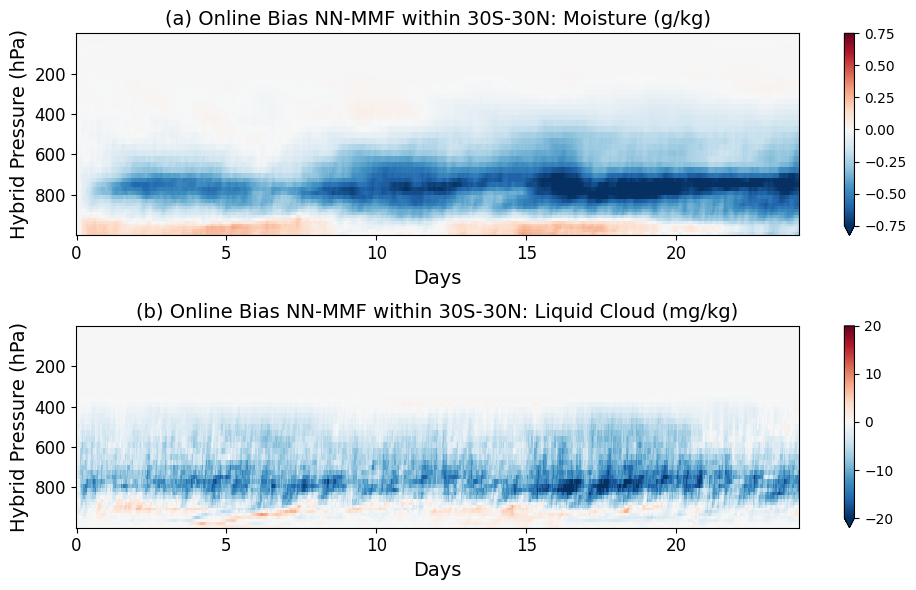

In [6]:
var = 'Q'
var_sp = ds_sp[var]
var_nn = ds_nn[var]
var_sp_re = np.transpose(var_sp.values, (2,0,1))
var_sp_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_sp_re, grid_area, lat)
var_nn_re = np.transpose(var_nn.values, (2,0,1))
var_nn_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_nn_re, grid_area, lat)

# average in tropics

var_sp_trop = var_sp_zonal_mean[6:12].mean(axis=0)
var_nn_trop = var_nn_zonal_mean[6:12].mean(axis=0)
data_sp = xr.DataArray(var_sp_trop.T, dims=["level", "time"],
                                   coords={"level": level, "time": np.arange(len(ds_sp.time))/24.})

data_nn = xr.DataArray(var_nn_trop.T, dims=["level", "time"],
                                   coords={"level": level, "time": np.arange(len(ds_nn.time))/24.})

bias_q= (data_nn-data_sp)

var = 'CLDLIQ'
var_sp = ds_sp[var]
var_nn = ds_nn[var]
var_sp_re = np.transpose(var_sp.values, (2,0,1))
var_sp_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_sp_re, grid_area, lat)
var_nn_re = np.transpose(var_nn.values, (2,0,1))
var_nn_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_nn_re, grid_area, lat)

# average in tropics

var_sp_trop = var_sp_zonal_mean[6:12].mean(axis=0)
var_nn_trop = var_nn_zonal_mean[6:12].mean(axis=0)
data_sp = xr.DataArray(var_sp_trop.T, dims=["level", "time"],
                                   coords={"level": level, "time": np.arange(len(ds_sp.time))/24.})

data_nn = xr.DataArray(var_nn_trop.T, dims=["level", "time"],
                                   coords={"level": level, "time": np.arange(len(ds_nn.time))/24.})

bias_qc= (data_nn-data_sp)

# Prepare the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

ax = axes[0]
(bias_q*1e3).plot(ax=ax, vmin = -.75, vmax = .75, cmap = 'RdBu_r')
ax.invert_yaxis()
# ax.set_xlim(0, 5)
ax.set_title('(a) Online Bias NN-MMF within 30S-30N: Moisture (g/kg)',fontsize=14)
ax.set_xlabel('Days',fontsize=14)
ax.set_ylabel('Hybrid Pressure (hPa)',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

ax = axes[1]
(bias_qc*1e6).plot(ax=ax, vmin = -20, vmax = 20, cmap = 'RdBu_r')
ax.invert_yaxis()
# ax.set_xlim(0, 5)
ax.set_title('(b) Online Bias NN-MMF within 30S-30N: Liquid Cloud (mg/kg)',fontsize=14)
ax.set_xlabel('Days',fontsize=14)
ax.set_ylabel('Hybrid Pressure (hPa)',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
# plt.savefig('/global/homes/z/zeyuanhu/notebooks/james-plots/error-growth.pdf', format='pdf', dpi=300, bbox_inches='tight')

# plt.tight_layout()
plt.show()

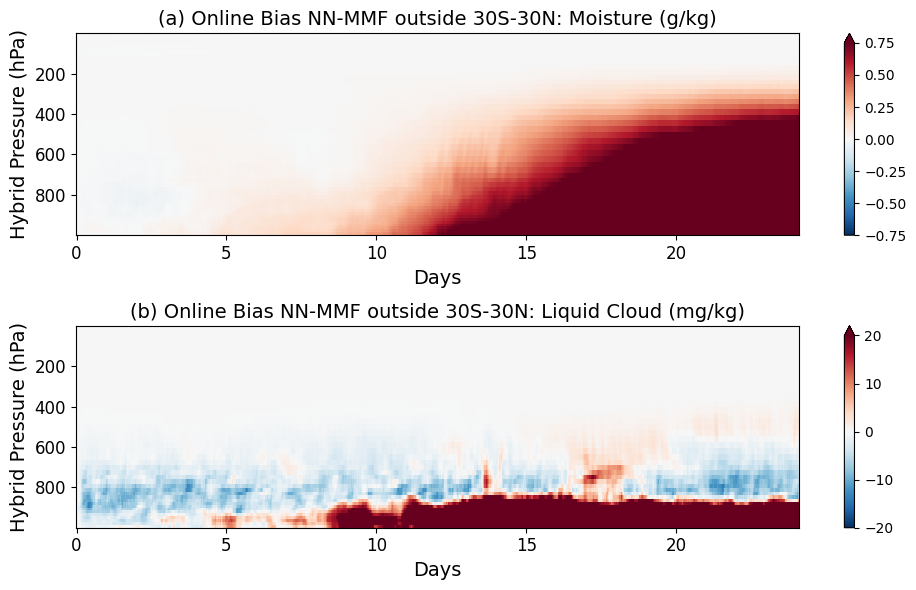

In [7]:
var = 'Q'
var_sp = ds_sp[var]
var_nn = ds_nn[var]
var_sp_re = np.transpose(var_sp.values, (2,0,1))
var_sp_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_sp_re, grid_area, lat)
var_nn_re = np.transpose(var_nn.values, (2,0,1))
var_nn_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_nn_re, grid_area, lat)

# average in extropics

var_sp_trop = var_sp_zonal_mean[np.r_[0:6, 12:18]].mean(axis=0)
var_nn_trop = var_nn_zonal_mean[np.r_[0:6, 12:18]].mean(axis=0)
data_sp = xr.DataArray(var_sp_trop.T, dims=["level", "time"],
                                   coords={"level": level, "time": np.arange(len(ds_sp.time))/24.})

data_nn = xr.DataArray(var_nn_trop.T, dims=["level", "time"],
                                   coords={"level": level, "time": np.arange(len(ds_nn.time))/24.})

bias_q = (data_nn-data_sp)

var = 'CLDLIQ'
var_sp = ds_sp[var]
var_nn = ds_nn[var]
var_sp_re = np.transpose(var_sp.values, (2,0,1))
var_sp_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_sp_re, grid_area, lat)
var_nn_re = np.transpose(var_nn.values, (2,0,1))
var_nn_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_nn_re, grid_area, lat)

# average in extropics

var_sp_trop = var_sp_zonal_mean[np.r_[0:6, 12:18]].mean(axis=0)
var_nn_trop = var_nn_zonal_mean[np.r_[0:6, 12:18]].mean(axis=0)
data_sp = xr.DataArray(var_sp_trop.T, dims=["level", "time"],
                                   coords={"level": level, "time": np.arange(len(ds_sp.time))/24.})

data_nn = xr.DataArray(var_nn_trop.T, dims=["level", "time"],
                                   coords={"level": level, "time": np.arange(len(ds_nn.time))/24.})

bias_qc= (data_nn-data_sp)

# Prepare the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

ax = axes[0]
(bias_q*1e3).plot(ax=ax, vmin = -.75, vmax = .75, cmap = 'RdBu_r')
ax.invert_yaxis()
# ax.set_xlim(0, 5)
ax.set_title('(a) Online Bias NN-MMF outside 30S-30N: Moisture (g/kg)',fontsize=14)
ax.set_xlabel('Days',fontsize=14)
ax.set_ylabel('Hybrid Pressure (hPa)',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

ax = axes[1]
(bias_qc*1e6).plot(ax=ax, vmin = -20, vmax = 20, cmap = 'RdBu_r')
ax.invert_yaxis()
# ax.set_xlim(0, 5)
ax.set_title('(b) Online Bias NN-MMF outside 30S-30N: Liquid Cloud (mg/kg)',fontsize=14)
ax.set_xlabel('Days',fontsize=14)
ax.set_ylabel('Hybrid Pressure (hPa)',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
# plt.savefig('/global/homes/z/zeyuanhu/notebooks/james-plots/error-growth.pdf', format='pdf', dpi=300, bbox_inches='tight')

# plt.tight_layout()
plt.show()

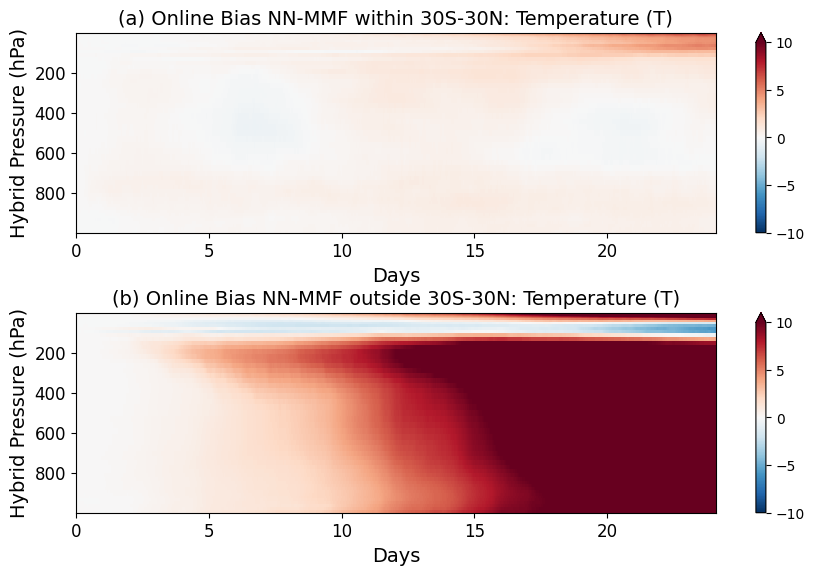

In [8]:
var = 'T'
var_sp = ds_sp[var]
var_nn = ds_nn[var]
var_sp_re = np.transpose(var_sp.values, (2,0,1))
var_sp_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_sp_re, grid_area, lat)
var_nn_re = np.transpose(var_nn.values, (2,0,1))
var_nn_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_nn_re, grid_area, lat)

# average in tropics

var_sp_trop = var_sp_zonal_mean[6:12].mean(axis=0)
var_nn_trop = var_nn_zonal_mean[6:12].mean(axis=0)
data_sp = xr.DataArray(var_sp_trop.T, dims=["level", "time"],
                                   coords={"level": level, "time": np.arange(len(ds_sp.time))/24.})

data_nn = xr.DataArray(var_nn_trop.T, dims=["level", "time"],
                                   coords={"level": level, "time": np.arange(len(ds_nn.time))/24.})

bias_t_tropics = (data_nn-data_sp)

var_sp_trop = var_sp_zonal_mean[np.r_[0:6, 12:18]].mean(axis=0)
var_nn_trop = var_nn_zonal_mean[np.r_[0:6, 12:18]].mean(axis=0)
data_sp = xr.DataArray(var_sp_trop.T, dims=["level", "time"],
                                   coords={"level": level, "time": np.arange(len(ds_sp.time))/24.})

data_nn = xr.DataArray(var_nn_trop.T, dims=["level", "time"],
                                   coords={"level": level, "time": np.arange(len(ds_nn.time))/24.})

bias_t_extratropics = (data_nn-data_sp)

# Prepare the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

ax = axes[0]
bias_t_tropics.plot(ax=ax, vmin = -10, vmax = 10, cmap = 'RdBu_r')
ax.invert_yaxis()
# ax.set_xlim(0, 5)
ax.set_title('(a) Online Bias NN-MMF within 30S-30N: Temperature (T)',fontsize=14)
ax.set_xlabel('Days',fontsize=14)
ax.set_ylabel('Hybrid Pressure (hPa)',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

ax = axes[1]
bias_t_extratropics.plot(ax=ax, vmin = -10, vmax = 10, cmap = 'RdBu_r')
ax.invert_yaxis()
# ax.set_xlim(0, 5)
ax.set_title('(b) Online Bias NN-MMF outside 30S-30N: Temperature (T)',fontsize=14)
ax.set_xlabel('Days',fontsize=14)
ax.set_ylabel('Hybrid Pressure (hPa)',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
plt.show()

In [9]:
ds_nn['T']

<xarray.DataArray 'T' (time: 579, lev: 60, ncol: 384)>
dask.array<concatenate, shape=(579, 60, 384), dtype=float32, chunksize=(1, 60, 384), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 0.07835 0.1411 0.2529 0.4493 ... 963.6 978.0 992.6
  * time     (time) object 0002-12-30 01:00:00 ... 0003-01-23 03:00:00
Dimensions without coordinates: ncol
Attributes:
    mdims:          1
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature
    cell_methods:   time: point

In [10]:
ds_nn['T'].shape

(579, 60, 384)

In [11]:
ds_nn['hybi'].shape

(579, 61)

In [12]:
grid_info['hybi'].values[:, np.newaxis, np.newaxis].shape

(61, 1, 1)

In [13]:
pressure_grid_p1 = np.array(grid_info['P0']*grid_info['hyai'])[np.newaxis,:,np.newaxis]
pressure_grid_p2 = grid_info['hybi'].values[np.newaxis,:,np.newaxis] * np.ones((1,61,384))*100000
pressure_grid_val = pressure_grid_p1 + pressure_grid_p2
dp_val = pressure_grid_val[:,1:61,:] - pressure_grid_val[:,0:60,:]
pressure_weights = dp_val/np.sum(dp_val, axis = 1)[:, np.newaxis, :]

In [14]:
nn_pressure_weighted_T = np.sum(ds_nn['T']*pressure_weights, axis = 1)
nn_pressure_weighted_Q = np.sum(ds_nn['Q']*pressure_weights, axis = 1)
sp_pressure_weighted_T = np.sum(ds_sp['T']*pressure_weights, axis = 1)
sp_pressure_weighted_Q = np.sum(ds_sp['Q']*pressure_weights, axis = 1)

In [15]:
sp_pressure_weighted_T.shape

(791, 384)

In [16]:
nn_pressure_weighted_T.shape

(579, 384)

In [17]:
lon.shape

(384,)

In [18]:
lat.shape

(384,)

In [19]:
def plot_map(values, title_text):
    # Create a figure and axis with a Robinson projection
    fig, ax = plt.subplots(
        subplot_kw={'projection': ccrs.Robinson()}, figsize=(12, 6)
    )

    # Add filled contours to the map
    contour = ax.tricontourf(
        lon, lat, values, 
        transform=ccrs.PlateCarree(),  # Data is in lat-lon coordinates
        cmap='coolwarm',  # Adjust colormap as needed
        levels=20,  # Number of contour levels
        extend='both'  # Extend beyond data range
    )

    # Add features like coastlines and borders
    ax.coastlines(linewidth=0.5, color='black')

    # Add a colorbar
    cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
    cbar.set_label('Temperature (K)')  # Adjust label to match your data

    # Set title
    ax.set_title('Global ' + title_text + ' - Robinson Projection', fontsize=16)
    ax.set_global()

    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    # Show the plot
    plt.show()

In [20]:
ds_nn['T'][0].shape

(60, 384)

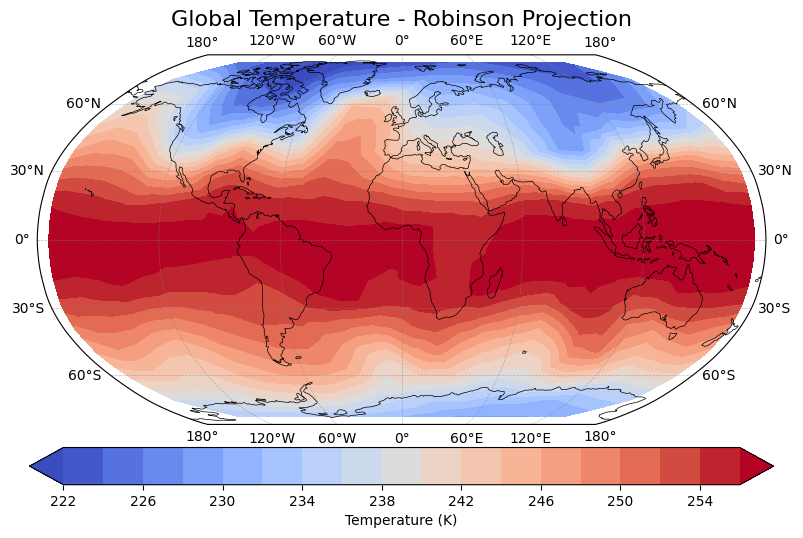

In [30]:
plot_map(nn_pressure_weighted_T[0], 'Temperature')

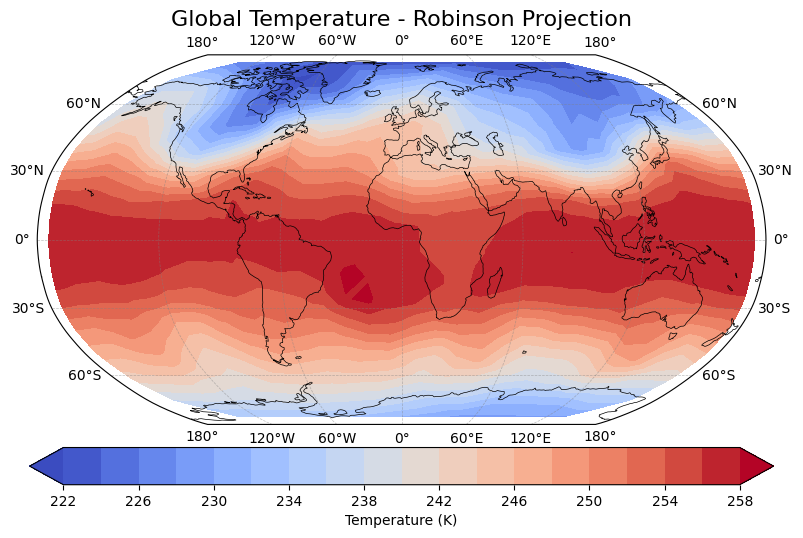

In [31]:
plot_map(nn_pressure_weighted_T[46], 'Temperature')

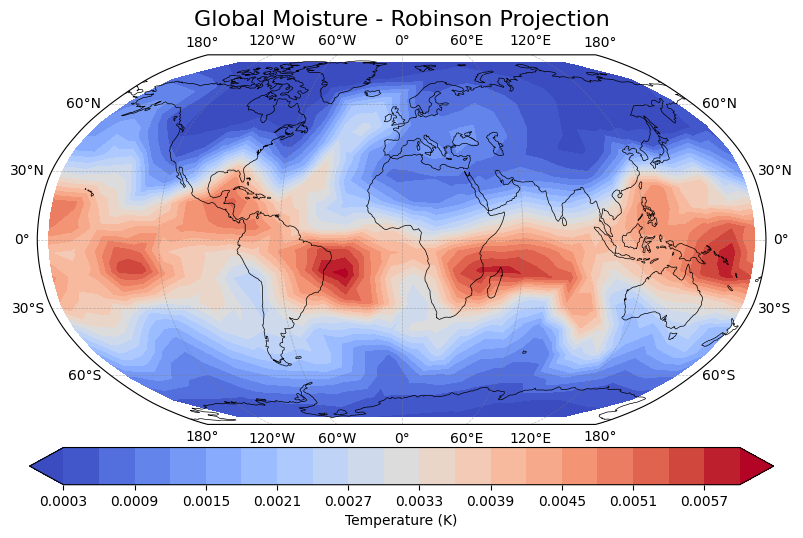

In [32]:
plot_map(nn_pressure_weighted_Q[0], 'Moisture')

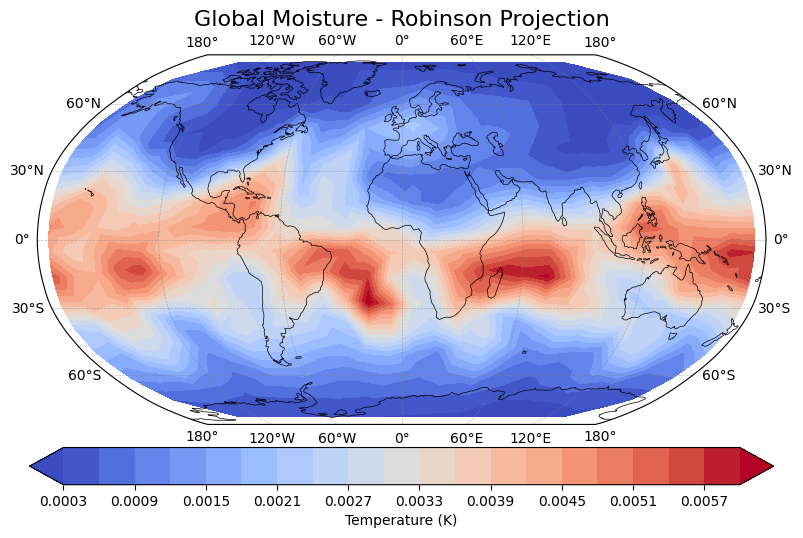

In [33]:
plot_map(nn_pressure_weighted_Q[46], 'Moisture')

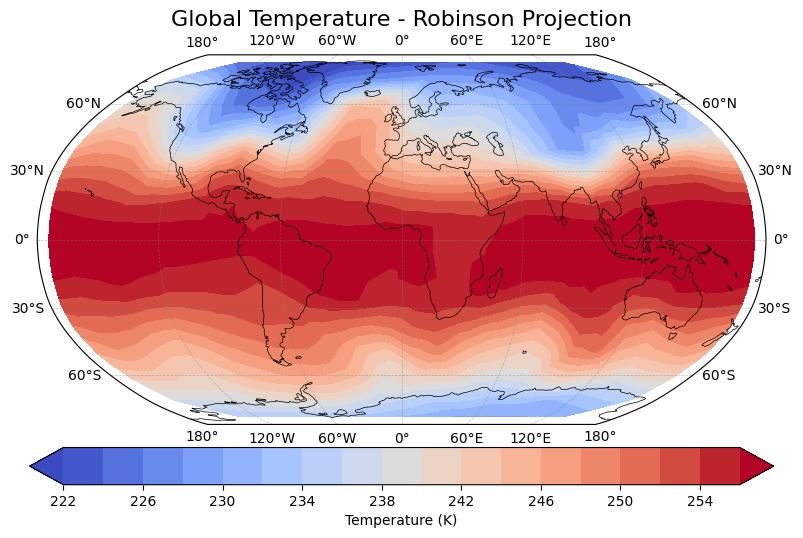

In [34]:
plot_map(sp_pressure_weighted_T[0], 'Temperature')

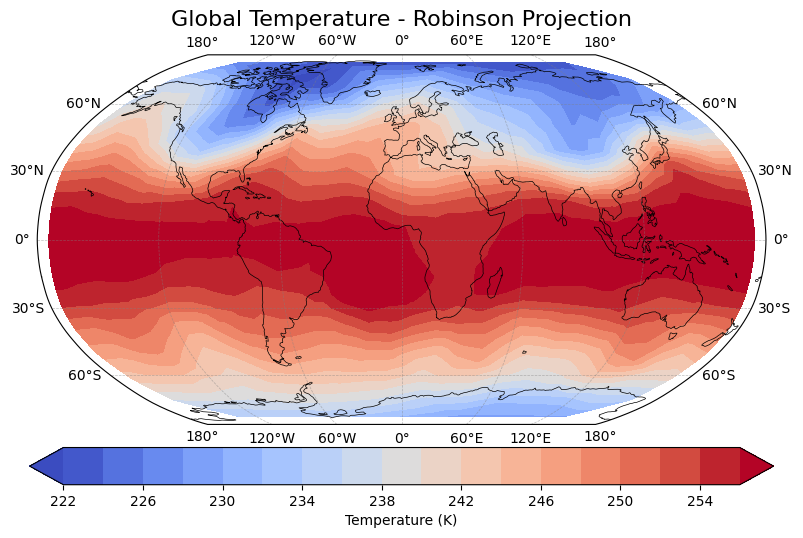

In [35]:
plot_map(sp_pressure_weighted_T[46], 'Temperature')

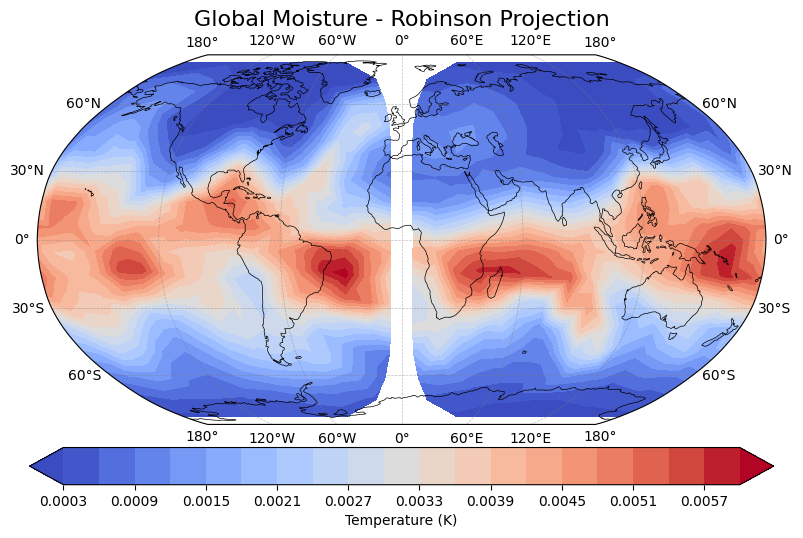

In [27]:
plot_map(sp_pressure_weighted_Q[0], 'Moisture')

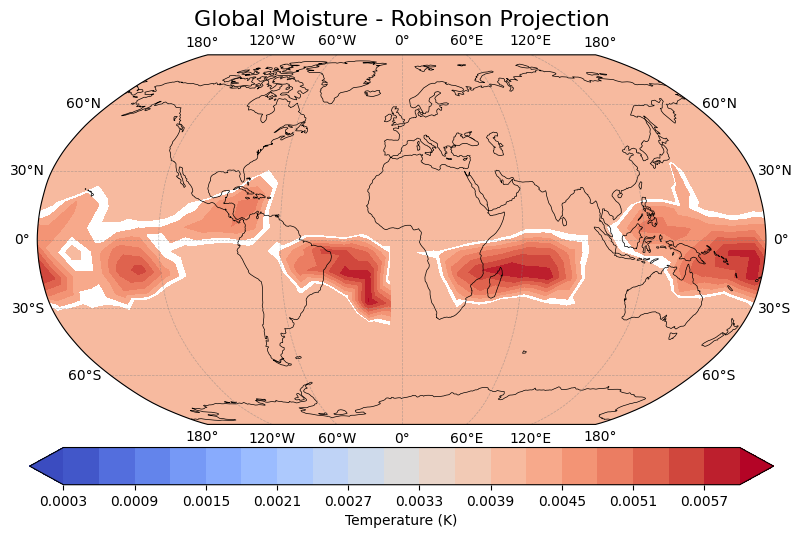

In [28]:
plot_map(sp_pressure_weighted_Q[46], 'Moisture')